In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import time
import numpy as np
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"


# 2. Тохиргоо
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

# 3. Хурдан тохиргоо
GAN_LATENT_DIM = 50      # Бага = хурдан
GAN_BATCH_SIZE = 64     # Их = хурдан  
GAN_EPOCHS = 15          # Бага = хурдан

VAE_LATENT_DIM = 10      # Бага = хурдан
VAE_HIDDEN_DIM = 200     # Бага = хурдан
VAE_EPOCHS = 20          # Бага = хурдан

Device: cpu


In [6]:
# 4. Өгөгдөл бэлтгэх
# GAN-д зориулсан өгөгдөл (-1 to 1)
gan_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # -1 to 1
])

# VAE-д зориулсан өгөгдөл (0 to 1)
vae_transform = transforms.Compose([
    transforms.ToTensor(),  # 0 to 1
])

# 5. MNIST өгөгдөл татах
print("MNIST өгөгдөл татаж байна...")
gan_dataset = datasets.MNIST(
    root='./data', 
    train=True, 
    download=True, 
    transform=gan_transform
)

vae_dataset = datasets.MNIST(
    root='./data',
    train=True,
    download=False,
    transform=vae_transform
)

# 6. DataLoader үүсгэх
gan_loader = DataLoader(gan_dataset, batch_size=GAN_BATCH_SIZE, shuffle=True)
vae_loader = DataLoader(vae_dataset, batch_size=GAN_BATCH_SIZE, shuffle=True)

print(f"GAN өгөгдөл: {len(gan_dataset)} зураг")
print(f"VAE өгөгдөл: {len(vae_dataset)} зураг")

MNIST өгөгдөл татаж байна...
GAN өгөгдөл: 60000 зураг
VAE өгөгдөл: 60000 зураг


In [11]:
# 7. GAN загвар - Generator
# Generator-д BatchNorm нэмэх (тохируулах хэрэгтэй, жишээ)
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(GAN_LATENT_DIM, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 784),
            nn.Tanh()
        )
    def forward(self, z):
        return self.main(z).view(-1, 1, 28, 28)


# 8. GAN загвар - Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(784, 128),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
    
    def forward(self, img):
        img_flat = img.view(-1, 784)
        return self.main(img_flat)

# 9. GAN загваруудыг үүсгэх
G = Generator().to(device)
D = Discriminator().to(device)

print("GAN загвар бэлэн боллоо")
print(f"Generator: {sum(p.numel() for p in G.parameters())} параметр")
print(f"Discriminator: {sum(p.numel() for p in D.parameters())} параметр")

GAN загвар бэлэн боллоо
Generator: 575120 параметр
Discriminator: 108801 параметр


In [12]:
# 10. GAN сургалтын бэлтгэл
optimizer_G = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
criterion = nn.BCELoss()

# 11. GAN сургалт
print("\n" + "="*25)
print("GAN learning...")
print("="*25)

gan_start_time = time.time()
d_losses = []
g_losses = []

for epoch in range(GAN_EPOCHS):
    epoch_start = time.time()
    epoch_d_loss = 0
    epoch_g_loss = 0
    
    for i, (real_imgs, _) in enumerate(gan_loader):
        batch_size = real_imgs.size(0)
        
        # Шошго үүсгэх
        real_labels = torch.ones(batch_size, 1) * 0.9
        fake_labels = torch.zeros(batch_size, 1).to(device)
        real_imgs = real_imgs.to(device)
        
        # ===== Discriminator сургах =====
        optimizer_D.zero_grad()
        
        # Жинхэнэ зураг
        real_outputs = D(real_imgs)
        d_real_loss = criterion(real_outputs, real_labels)
        
        # Хуурамч зураг
        z = torch.randn(batch_size, GAN_LATENT_DIM).to(device)
        fake_imgs = G(z)
        fake_outputs = D(fake_imgs.detach())
        d_fake_loss = criterion(fake_outputs, fake_labels)
        
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        optimizer_D.step()
        
        # ===== Generator сургах =====
        optimizer_G.zero_grad()
        
        z = torch.randn(batch_size, GAN_LATENT_DIM).to(device)
        fake_imgs = G(z)
        outputs = D(fake_imgs)
        g_loss = criterion(outputs, real_labels)
        
        g_loss.backward()
        optimizer_G.step()
        
        # Loss хадгалах
        epoch_d_loss += d_loss.item()
        epoch_g_loss += g_loss.item()
    
    # Эпохын дундаж loss
    avg_d = epoch_d_loss / len(gan_loader)
    avg_g = epoch_g_loss / len(gan_loader)
    d_losses.append(avg_d)
    g_losses.append(avg_g)
    
    # Хугацаа
    epoch_time = time.time() - epoch_start
    print(f"Epoch {epoch+1}/{GAN_EPOCHS} - D loss: {avg_d:.3f}, G loss: {avg_g:.3f}, Time: {epoch_time:.1f}s")

gan_total_time = time.time() - gan_start_time
print(f"GAN сургалт дууслаа. Нийт хугацаа: {gan_total_time:.1f} секунд")


GAN learning...
Epoch 1/15 - D loss: 1.333, G loss: 0.795, Time: 26.0s
Epoch 2/15 - D loss: 1.254, G loss: 1.007, Time: 26.4s
Epoch 3/15 - D loss: 1.283, G loss: 0.962, Time: 25.4s
Epoch 4/15 - D loss: 1.288, G loss: 0.934, Time: 26.2s
Epoch 5/15 - D loss: 1.308, G loss: 0.897, Time: 25.6s
Epoch 6/15 - D loss: 1.315, G loss: 0.880, Time: 26.4s
Epoch 7/15 - D loss: 1.327, G loss: 0.858, Time: 26.9s
Epoch 8/15 - D loss: 1.331, G loss: 0.851, Time: 26.9s
Epoch 9/15 - D loss: 1.343, G loss: 0.833, Time: 25.3s
Epoch 10/15 - D loss: 1.352, G loss: 0.826, Time: 26.7s
Epoch 11/15 - D loss: 1.356, G loss: 0.820, Time: 26.6s
Epoch 12/15 - D loss: 1.357, G loss: 0.818, Time: 26.1s
Epoch 13/15 - D loss: 1.358, G loss: 0.816, Time: 35.0s
Epoch 14/15 - D loss: 1.358, G loss: 0.814, Time: 36.0s
Epoch 15/15 - D loss: 1.358, G loss: 0.813, Time: 35.3s
GAN сургалт дууслаа. Нийт хугацаа: 420.9 секунд



GAN зураг үүсгэж байна...


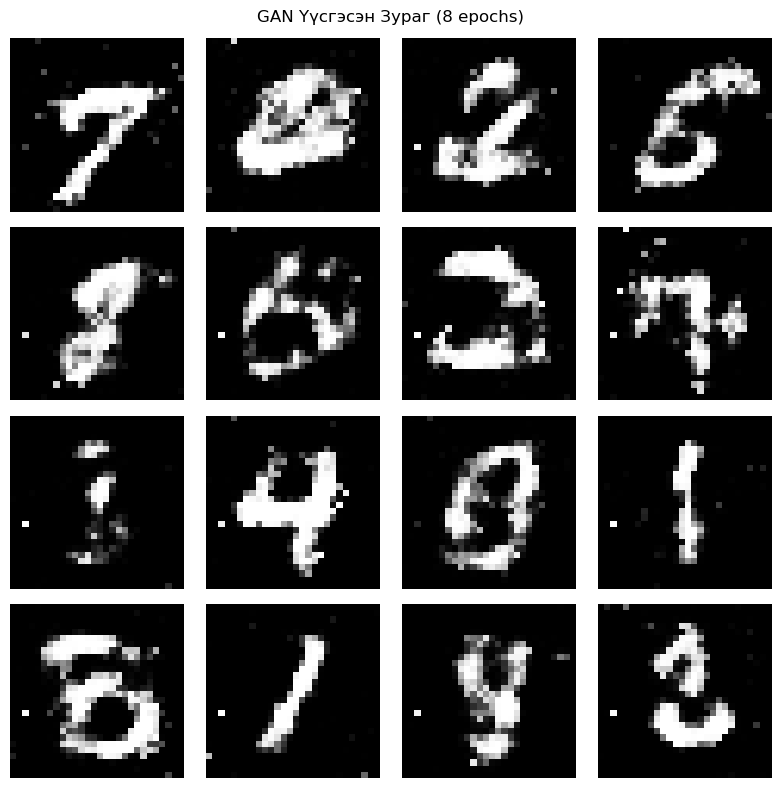

GAN 16 шинэ зураг үүсгэлээ


In [13]:
# 12. GAN ашиглан шинэ зураг үүсгэх
print("\nGAN зураг үүсгэж байна...")

# 16 шинэ зураг үүсгэх
z = torch.randn(16, GAN_LATENT_DIM).to(device)
with torch.no_grad():
    gan_images = G(z).cpu()

# -1 to 1 → 0 to 1 руу хөрвүүлэх
gan_images = (gan_images + 1) / 2
gan_images = gan_images.view(-1, 28, 28)

# Зургийг харуулах
fig, axes = plt.subplots(4, 4, figsize=(8, 8))
for i in range(16):
    row = i // 4
    col = i % 4
    axes[row, col].imshow(gan_images[i], cmap='gray')
    axes[row, col].axis('off')

plt.suptitle('GAN Үүсгэсэн Зураг (8 epochs)')
plt.tight_layout()
plt.show()

print(f"GAN {len(gan_images)} шинэ зураг үүсгэлээ")

In [7]:
# 13. VAE загвар
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        # Encoder
        self.fc1 = nn.Linear(784, VAE_HIDDEN_DIM)
        self.fc21 = nn.Linear(VAE_HIDDEN_DIM, VAE_LATENT_DIM)  # mean
        self.fc22 = nn.Linear(VAE_HIDDEN_DIM, VAE_LATENT_DIM)  # logvar
        
        # Decoder
        self.fc3 = nn.Linear(VAE_LATENT_DIM, VAE_HIDDEN_DIM)
        self.fc4 = nn.Linear(VAE_HIDDEN_DIM, 784)
    
    def encode(self, x):
        h = torch.relu(self.fc1(x))
        return self.fc21(h), self.fc22(h)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        h = torch.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h))
    
    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# 14. VAE loss функц
def vae_loss(recon_x, x, mu, logvar):
    # Reconstruction loss
    BCE = nn.functional.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    # KL divergence
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# 15. VAE загвар үүсгэх
vae_model = VAE().to(device)
print(f"\nVAE загвар бэлэн боллоо")
print(f"VAE: {sum(p.numel() for p in vae_model.parameters())} параметр")


VAE загвар бэлэн боллоо
VAE: 320804 параметр


In [ ]:
# 16. VAE сургалт
vae_optimizer = optim.Adam(vae_model.parameters(), lr=0.0005)

print("\n" + "="*25)
print("VAE learning...")
print("="*25)

vae_start_time = time.time()
vae_losses = []

for epoch in range(VAE_EPOCHS):
    epoch_start = time.time()
    train_loss = 0
    
    for batch_idx, (data, _) in enumerate(vae_loader):
        data = data.to(device)
        vae_optimizer.zero_grad()
        
        recon_batch, mu, logvar = vae_model(data)
        loss = vae_loss(recon_batch, data, mu, logvar)
        
        loss.backward()
        train_loss += loss.item()
        vae_optimizer.step()
    
    avg_loss = train_loss / len(vae_loader.dataset)
    vae_losses.append(avg_loss)
    
    epoch_time = time.time() - epoch_start
    print(f"VAE Epoch {epoch+1}/{VAE_EPOCHS} - Loss: {avg_loss:.1f}, Time: {epoch_time:.1f}s")

vae_total_time = time.time() - vae_start_time
print(f"VAE сургалт дууслаа. Нийт хугацаа: {vae_total_time:.1f} секунд")


VAE СУРГАЛТ ЭХЭЛЛЭЭ
VAE Epoch 1/20 - Loss: 157.0, Time: 13.4s
VAE Epoch 2/20 - Loss: 125.4, Time: 14.2s
VAE Epoch 3/20 - Loss: 120.6, Time: 14.5s
VAE Epoch 4/20 - Loss: 118.1, Time: 14.3s
VAE Epoch 5/20 - Loss: 116.5, Time: 13.9s
VAE Epoch 6/20 - Loss: 115.4, Time: 13.7s
VAE Epoch 7/20 - Loss: 114.5, Time: 13.9s
VAE Epoch 8/20 - Loss: 113.9, Time: 14.1s
VAE Epoch 9/20 - Loss: 113.3, Time: 14.2s
VAE Epoch 10/20 - Loss: 112.8, Time: 14.1s
VAE Epoch 11/20 - Loss: 112.4, Time: 14.1s
VAE Epoch 12/20 - Loss: 112.0, Time: 18.2s
VAE Epoch 13/20 - Loss: 111.7, Time: 16.7s
VAE Epoch 14/20 - Loss: 111.4, Time: 14.5s
VAE Epoch 15/20 - Loss: 111.2, Time: 13.5s
VAE Epoch 16/20 - Loss: 110.9, Time: 13.9s
VAE Epoch 17/20 - Loss: 110.6, Time: 15.0s
VAE Epoch 18/20 - Loss: 110.4, Time: 14.1s
VAE Epoch 19/20 - Loss: 110.2, Time: 14.5s
VAE Epoch 20/20 - Loss: 110.0, Time: 14.7s
VAE сургалт дууслаа. Нийт хугацаа: 289.5 секунд



VAE зураг үүсгэж байна...


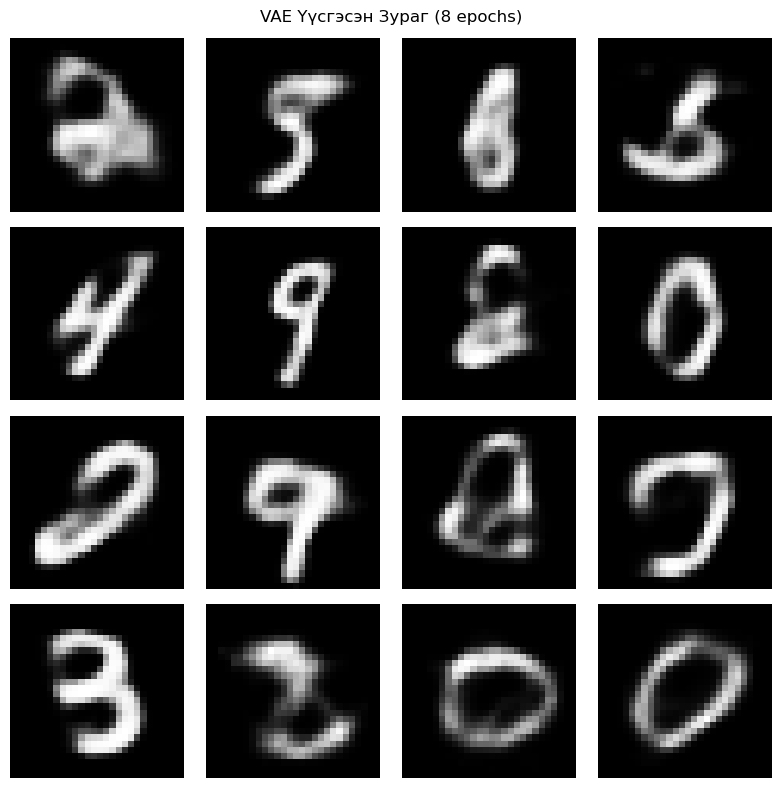

VAE 16 шинэ зураг үүсгэлээ


In [9]:
# 17. VAE ашиглан шинэ зураг үүсгэх
print("\nVAE зураг үүсгэж байна...")

# 16 шинэ зураг үүсгэх
z = torch.randn(16, VAE_LATENT_DIM).to(device)
with torch.no_grad():
    vae_images = vae_model.decode(z).cpu()

vae_images = vae_images.view(-1, 28, 28)

# Зургийг харуулах
fig, axes = plt.subplots(4, 4, figsize=(8, 8))
for i in range(16):
    row = i // 4
    col = i % 4
    axes[row, col].imshow(vae_images[i], cmap='gray')
    axes[row, col].axis('off')

plt.suptitle('VAE Үүсгэсэн Зураг (8 epochs)')
plt.tight_layout()
plt.show()

print(f"VAE {len(vae_images)} шинэ зураг үүсгэлээ")

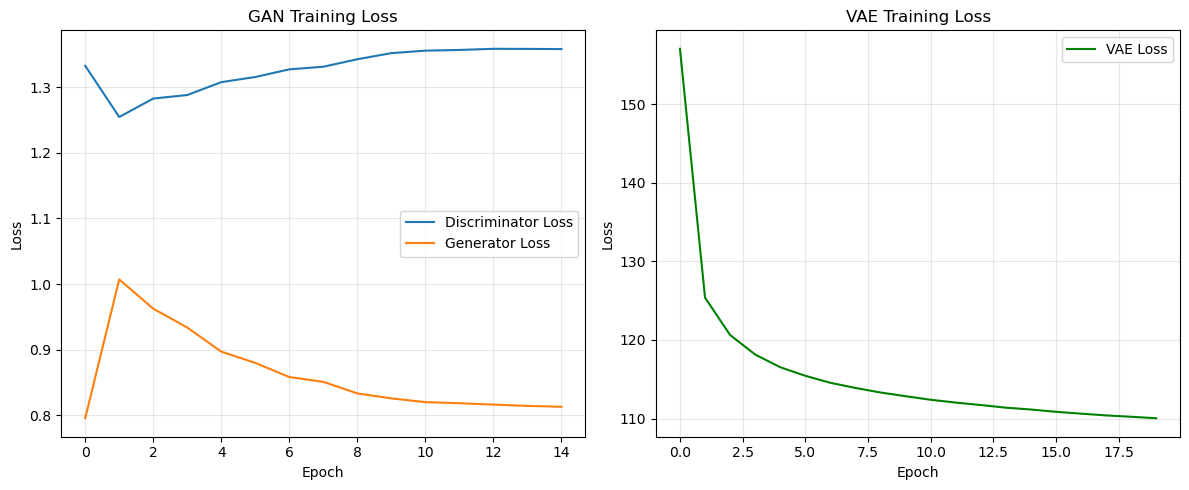


ХАРЬЦУУЛАЛТЫН ДҮН


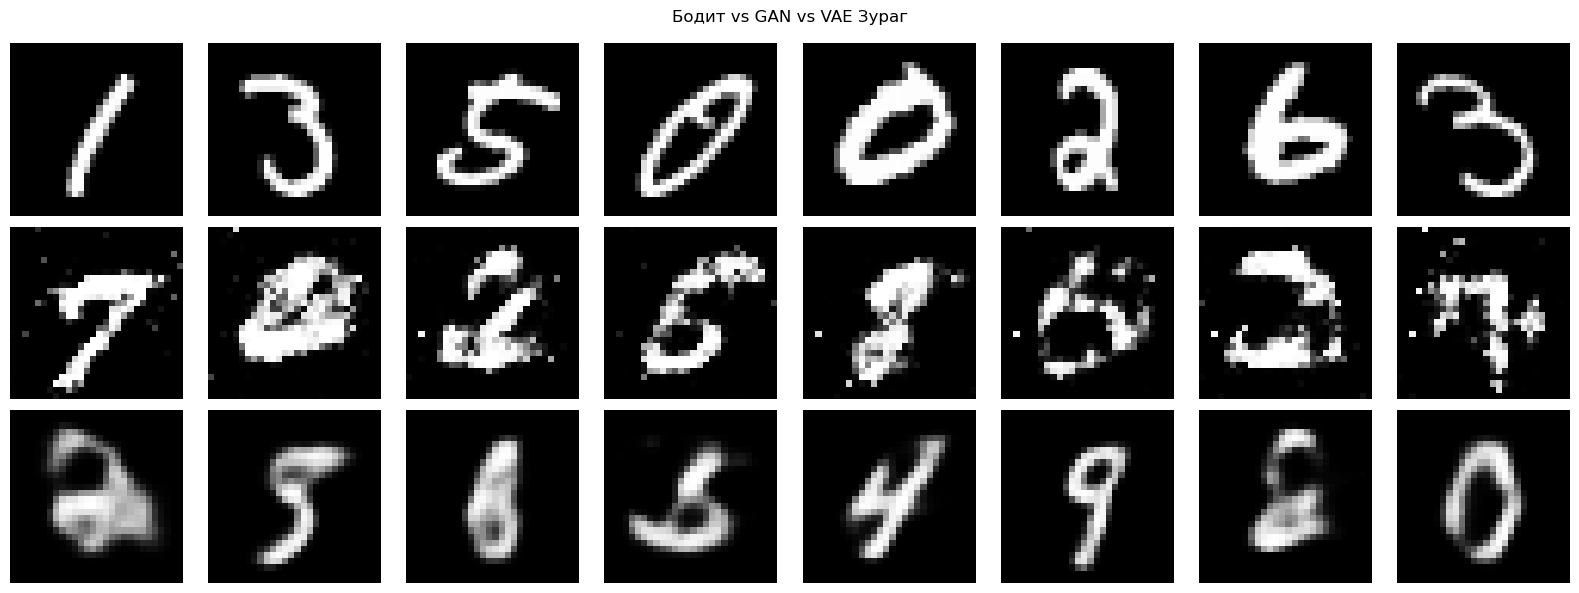


ТУРШИЛТЫН ТОВЧ ТАЙЛАН:
1. GAN сургалт: 420.9 секунд
2. VAE сургалт: 289.5 секунд
3. Нийт хугацаа: 710.4 секунд
4. GAN үүсгэсэн: 16 шинэ цифр
5. VAE үүсгэсэн: 16 шинэ цифр
6. GAN final loss: D=1.358, G=0.813
7. VAE final loss: 110.0

Загварууд 'gan_generator.pth', 'gan_discriminator.pth', 'vae_model.pth' файлуудад хадгалагдлаа.


In [14]:
# 18. Loss графикууд
plt.figure(figsize=(12, 5))

# GAN loss
plt.subplot(1, 2, 1)
plt.plot(d_losses, label='Discriminator Loss')
plt.plot(g_losses, label='Generator Loss')
plt.title('GAN Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# VAE loss
plt.subplot(1, 2, 2)
plt.plot(vae_losses, label='VAE Loss', color='green')
plt.title('VAE Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 19. Бодит байдал дээр харьцуулах
print("\n" + "="*50)
print("ХАРЬЦУУЛАЛТЫН ДҮН")
print("="*50)

# Бодит зураг авах
real_batch = next(iter(gan_loader))[0][:16]
real_images = real_batch.cpu()

# -1 to 1 → 0 to 1
real_images = (real_images + 1) / 2
real_images = real_images.view(-1, 28, 28)

# Гурван төрлийн зургийг харьцуулах
fig, axes = plt.subplots(3, 8, figsize=(16, 6))

# Эхний мөр: Бодит зураг
for i in range(8):
    axes[0, i].imshow(real_images[i], cmap='gray')
    axes[0, i].axis('off')
axes[0, 0].set_ylabel('Бодит', fontsize=12)

# Хоёр дахь мөр: GAN зураг
for i in range(8):
    axes[1, i].imshow(gan_images[i], cmap='gray')
    axes[1, i].axis('off')
axes[1, 0].set_ylabel('GAN', fontsize=12)

# Гурав дахь мөр: VAE зураг
for i in range(8):
    axes[2, i].imshow(vae_images[i], cmap='gray')
    axes[2, i].axis('off')
axes[2, 0].set_ylabel('VAE', fontsize=12)

plt.suptitle('Бодит vs GAN vs VAE Зураг')
plt.tight_layout()
plt.show()

# 20. Тайлан
print(f"\nТУРШИЛТЫН ТОВЧ ТАЙЛАН:")
print(f"1. GAN сургалт: {gan_total_time:.1f} секунд")
print(f"2. VAE сургалт: {vae_total_time:.1f} секунд")
print(f"3. Нийт хугацаа: {gan_total_time + vae_total_time:.1f} секунд")
print(f"4. GAN үүсгэсэн: 16 шинэ цифр")
print(f"5. VAE үүсгэсэн: 16 шинэ цифр")
print(f"6. GAN final loss: D={d_losses[-1]:.3f}, G={g_losses[-1]:.3f}")
print(f"7. VAE final loss: {vae_losses[-1]:.1f}")

# 21. Загварууд хадгалах
torch.save(G.state_dict(), 'gan_generator.pth')
torch.save(D.state_dict(), 'gan_discriminator.pth')
torch.save(vae_model.state_dict(), 'vae_model.pth')
print("\nЗагварууд 'gan_generator.pth', 'gan_discriminator.pth', 'vae_model.pth' файлуудад хадгалагдлаа.")

In [ ]:
# 22. Текст үүсгэлт (хэрэгтэй бол)
print("\n" + "="*50)
print("ТЕКСТ ҮҮСГЭЛТ (НЭМЭЛТ)")
print("="*50)

try:
    from transformers import pipeline
    
    # GPT-2 жижиг загвар ашиглах
    print("GPT-2 загвар ачаалж байна...")
    text_generator = pipeline('text-generation', model='gpt2', framework='pt', max_length=150)
    
    # Текст үүсгэх
    generated = text_generator("Artificial intelligence is", num_return_sequences=1)[0]
    
    print("\nҮүсгэсэн текст:")
    print("-" * 50)
    print(generated['generated_text'])
    print("-" * 50)
    
except Exception as e:
    print(f"Текст үүсгэлтийн алдаа: {e}")
    print("Энэ хэсгийг алгасаж болно.")


ТЕКСТ ҮҮСГЭЛТ (НЭМЭЛТ)
GPT-2 загвар ачаалж байна...


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

c:\Users\user\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\user\.cache\huggingface\hub\models--gpt2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cpu
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



Үүсгэсэн текст:
--------------------------------------------------
Artificial intelligence is now making the rounds to try and make sense of the world around us, from cars to the Internet. And in the process, we're seeing a big, new direction for artificial intelligence at work.

In the past few
--------------------------------------------------
